In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.sparse import diags
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


In [ ]:
def initial_time(t,c,u0):
    return u0*np.exp(-c*t)

def alpha(k,m,sig,r):
    return k*m*(m*sig**2 + r)/(2)

def beta(k,m,sig,c):
    return k*((m*sig)**2 + c)

def gamma(k,m,sig,r):
    return k*m*(m*sig**2 - r)/(2)

def test_func(x,t):
    return np.exp(-t)*np.cos(x)
    
#the scheme with a known function
def LF(x,t,f,sig,r,c):
    return -f(x,t) - f(x,t)*0.5*(sig*x)**2 + r*x*f(x,t) + c*f(x,t)


Maximum value: 1.0


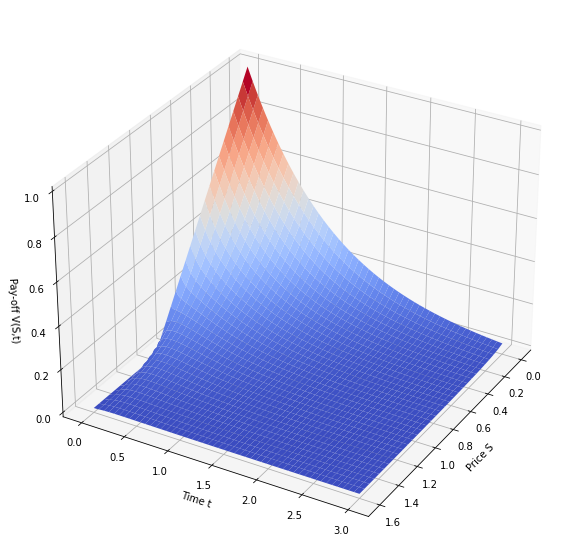

Maximum value: 1.0


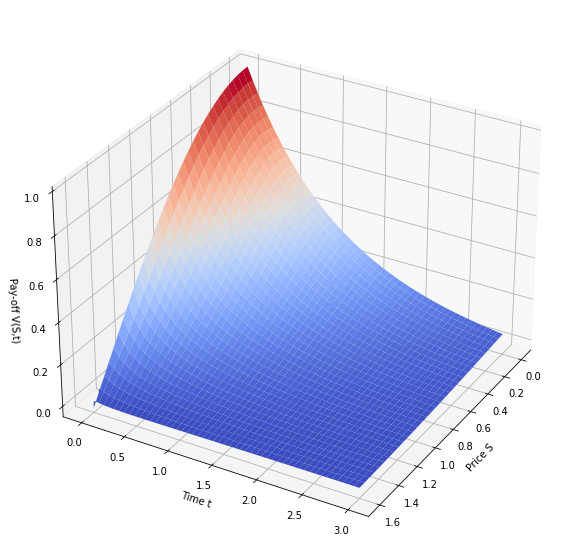

With step sizes h=0.05 and k=0.001, the absolute maximum error for this forced solution is 0.12907559485635373


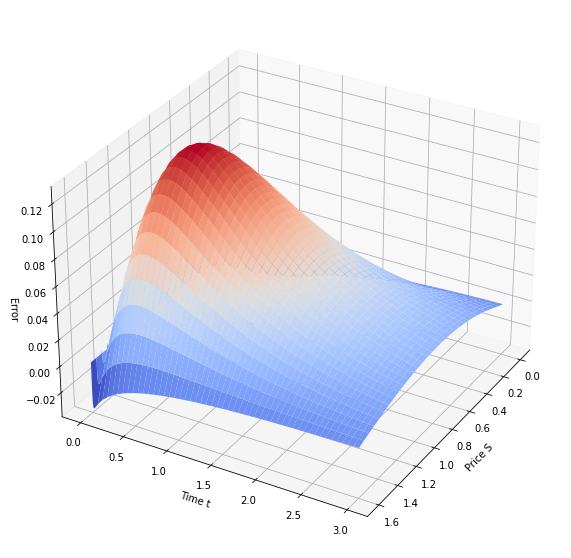

In [ ]:
k = 0.001
h = 0.05

C = 1
R = 1
S = 1
strike = 1

#####
#Explicit
#####
#space
first = 0
last = 1.6

#time
start = 0
stp = 3

M1 = int(last/h)
N1 = int(stp/k)

#initalvalues
x0 = np.linspace(first,last,M1)

for i in range(len(x0)):
    x0[i] = max(strike - x0[i],0)


t = np.linspace(0,stp,N1)
T0 = initial_time(t,C,x0[0])

T = np.zeros((2,N1))
T[0] = T0



def Euler(h,k,xbound,tbounds,f,endcoords = (1,1), S = 1, R = 1,C = 1,show = True):
    """
    Explisitt Eulers mhtode
    h: float, step length in space
    k: float, step length in time
    xbound: array, initalvalues for x, so when t=0
    tbounds: array, 2xN array with boundaryvalues for x = 0 and x = R
    endcoords: array, 2 values, last value for x and t
    f: arr, 2D array with values for a known solution Lf, 0-array for generel solution
    show: Bool, plots solution if True.
    ###
    return: array, the soltuion U
    """
    #needed steps are calulated
    N = len(tbounds[0])
    M = len(xbound)

    D2 = np.arange(1,M+2)
    d2 = np.arange(1,M+1)

    dia2 = 1 - beta(k,D2,S,C)
    supdi2 = alpha(k,d2[0:-1:],S,R)
    subdi2 = gamma(k,d2[1::],S,R)

    A = diags([subdi2,dia2,supdi2],[-1,0,1],shape = (M,M)).toarray()


    t = np.linspace(0,endcoords[1],N)
    x = np.linspace(0,endcoords[0],M)

    #soltuion array
    U = np.zeros((N,M),dtype = float)

    #boundaryvalues
    U[0] = xbound
    U[:,0] = tbounds[0]
    U[:,-1] = tbounds[1]
    
    

    #Her regner vi ut
    for i in range(1,N):
        b = U[i]
        b[0] *= gamma(k,1,S,R)
        b[-1] *= alpha(k,M-1,S,R)
        U[i] = np.dot(A,U[i-1]) + b + k*f[i]

    if show:
        xv,tv = np.meshgrid(x,t)

        fig = plt.figure(figsize = (10,10))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(xv,tv,U,cmap=cm.coolwarm)
        ax.view_init(azim=30)
        ax.set_ylabel("Time t")
        ax.set_xlabel("Price S")
        ax.set_zlabel("Pay-off V(S,t)")

        print("Maximum value: "+str(np.amax(U)))
        plt.show()

    return U


f0 = np.zeros((N1,M1),dtype = float)
BlSc = Euler(h,k,x0,T,f0,endcoords = (last,stp))


#####
#forced solution
####

#New arrays
x1 = np.linspace(first,last,M1)
t1 = np.linspace(0,stp,N1)

#new inital and boundary values
Ttest = np.zeros((2,N1))
testInit = test_func(x1,0)
Ttest[0] = test_func(0,t1)
Ttest[1] = test_func(last,t1)


x1v,t1v = np.meshgrid(x1,t1)
analytic = test_func(x1v,t1v)
fvals = LF(x1v,t1v,test_func,S,R,C)


forced = Euler(h,k,testInit,Ttest,fvals,endcoords = (last,stp))
err = analytic - forced
maxerr = np.amax(abs(err))

print(f"With step sizes h={h} and k={k}, the absolute maximum error for this forced solution is {maxerr}")
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1v,t1v,err, cmap=cm.coolwarm)
ax.view_init(azim=30)
ax.set_ylabel("Time t")
ax.set_xlabel("Price S")
ax.set_zlabel("Error")

plt.show()

Maximum value: 2.0


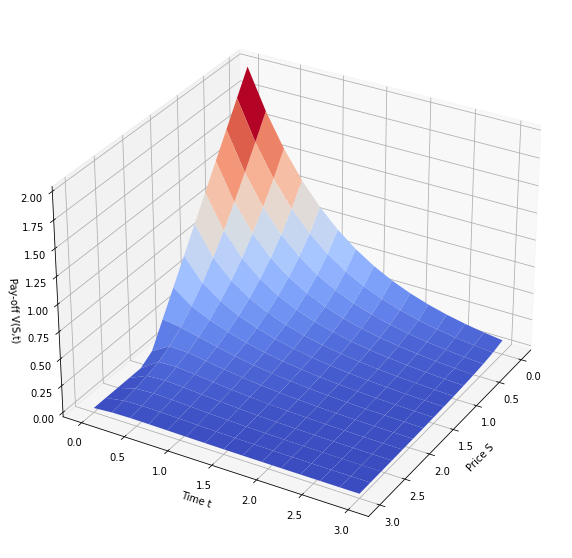

Maximum value: 1.0


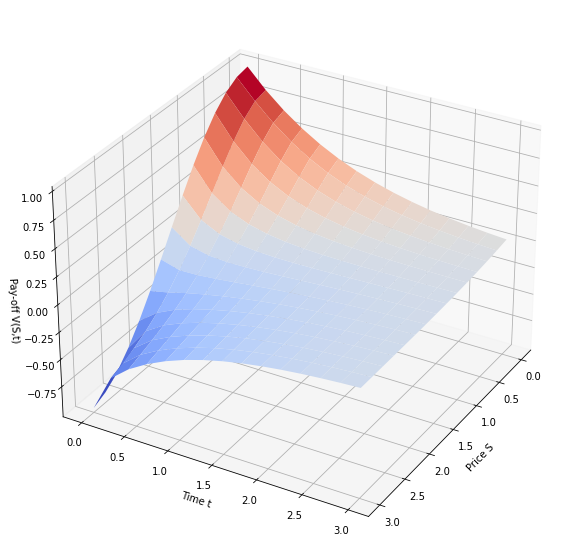

0.17535049899880722


In [ ]:
####
#Implicit
####
strike = 2
k2 = 0.2
h2 = 0.2

last2 = 3
stp2 = 3

M2 = int(last2/h2)
N2 = int(stp2/k2)

C = 1
R = 1
S = 1

#making initalvalues
x2 = np.linspace(0,last2,M2)

for i in range(len(x2)):
    x2[i] = max(strike - x2[i],0)

t2 = np.linspace(0,stp2,N2)
init2 = initial_time(t2,C,x2[0])

T2 = np.zeros((2,N2))
T2[0] = init2

f0 = np.zeros((N2,M2),dtype = float)

def impEuler(h,k,xbound,tbounds,f,endcoords = (1,1),S = 1, R = 1,show = True):
    """
    Implisitt Eulers metode, hvor det er antatt at systemet er lineært, og den tridiagonale matrisen da er inverterbar
    h: float, steplength in space
    k: float, steplength in time
    xbound: array, initalvalues for x, so when t=0
    tbounds: array, 2xN array with boundaryvalues for x = 0 and x = R
    endcoords: array, 2 values, last value for x and t
    f: arr, 2D array with values for a known solution Lf, 0-array for generel solution
    show: Bool, plots solution if True.
    ###
    return: array, the soltuion U
    """
    
    #how many steps?
    N = len(tbounds[0])
    M = len(xbound)

    D2 = np.arange(1,M+2)
    d2 = np.arange(1,M+1)

    dia2 = 1 + beta(k,D2,S,C)
    supdi2 = -alpha(k,d2[0:-1:],S,R)
    subdi2 = -gamma(k,d2[1::],S,R)

    A = diags([subdi2,dia2,supdi2],[-1,0,1],shape = (M,M)).toarray()

    t = np.linspace(0,endcoords[1],N)
    x = np.linspace(0,endcoords[0],M)

    #soltuion array
    U = np.zeros((N,M),dtype = float)

    #boundary values
    U[0] = xbound
    U[:,0] = tbounds[0]
    U[:,-1] = tbounds[1]

    #gamma_1 and alpha M-1
    G1 = gamma(k,1,S,R)
    Am1 = alpha(k,M-1,S,R)

    #solving
    for i in range(1,N):
        b = U[i-1] + k*f[i]

        #adding boundarvalues
        b[0] += G1*U[i][0]
        b[-1] += Am1*U[i][-1]

        a = np.linalg.solve(A,b)
        U[i] = a 

    if show:
        xv,tv = np.meshgrid(x,t)
        
        fig = plt.figure(figsize = (10,10))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(xv,tv,U, cmap=cm.coolwarm)
        ax.view_init(azim=30)
        ax.set_ylabel("Time t")
        ax.set_xlabel("Price S")
        ax.set_zlabel("Pay-off V(S,t)")

        print("Maximum value: "+str(np.amax(U)))
        plt.show()

    return U

bro = impEuler(h2,k2,x2,T2,f0,endcoords = (last2,stp2))

#New arrays
x2 = np.linspace(0,last2,M2)
t2 = np.linspace(0,stp2,N2)

#new inital and boundary values
Ttest = np.zeros((2,N2))
testInit = test_func(x2,0)
Ttest[0] = test_func(0,t2)
Ttest[1] = test_func(last2,t2)

x2v,t2v = np.meshgrid(x2,t2)
analytic = test_func(x2v,t2v)
fvals = LF(x2v,t2v,test_func,S,R,C)

forced = impEuler(h2,k2,testInit,Ttest,fvals,endcoords = (last2,stp2))
err = analytic - forced
maxerr = np.amax(abs(err))
print(maxerr)

Maximum value: 2.0


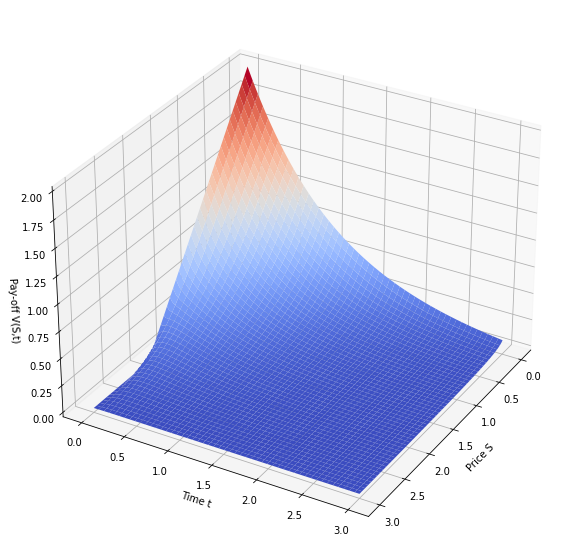

Maximum value: 1.0


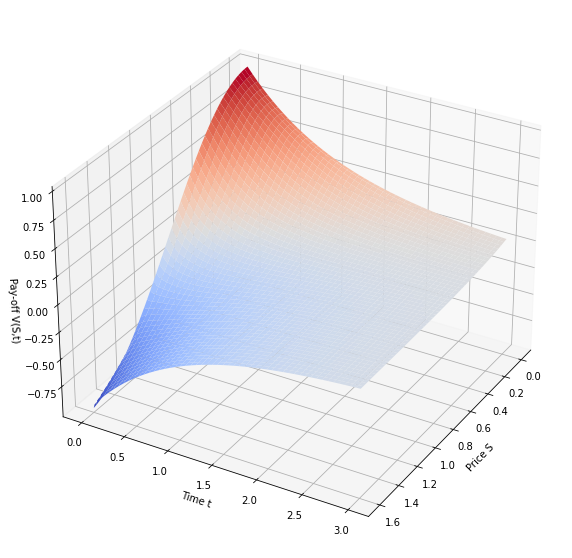

In [ ]:
####
#Crank - Nicolson
####

strike = 2
h3 = 0.01
k3 = 0.01
stp3 = 3
last3 = 3
C = 1
R = 1
S = 1

N3 = int(stp3/k3)
M3 = int(last3/h3)

D3 = np.arange(1,M3+2)
d3 = np.arange(1,M3+1)

dia3_1 = 1 - beta(k3,D3,S,C)/2
dia3_2 = 1 + beta(k3,D3,S,C)/2

supdi3 = -alpha(k3,d3[0:-1:],S,R)/2
subdi3 = -gamma(k3,d3[1::],S,R)/2

m1 = diags([subdi3,dia3_2,supdi3],[-1,0,1],shape = (M3,M3)).toarray() #nåtid
m2 = diags([-subdi3,dia3_1,-supdi3],[-1,0,1],shape = (M3,M3)).toarray() #framtid

#Her lager vi initalverdier
x3 = np.linspace(0,last3,M3)
t3 = np.linspace(0,stp3,N3)

for i in range(len(x3)):
    x3[i] = max(strike - x3[i],0)

init3 = initial_time(t3,C,x3[0])

T3 = np.zeros((2,N3))
T3[0] = init3

f3 = np.zeros((N3,M3),dtype = float)

def crankNicolson(h,k,xbound,tbounds,f,endcoords = (1,1),S = 1, R =1,show = True):
    """
    Crank - Nicolson metode, hvor det er antatt at systemet er lineært, og matrisene har full rank
    h: float, steplength in space
    k: float, steplength in time
    xbound: array, initalvalues for x, so when t=0
    tbounds: array, 2xN array with boundaryvalues for x = 0 and x = R
    endcoords: array, 2 values, last value for x and t
    f: arr, 2D array with values for a known solution Lf, 0-array for generel solution
    show: Bool, plots solution if True.
    ###
    return: array, the soltuion U
    """
    #Hvor mange steg trenger vi for å komme i mål?
    N = len(tbounds[0])
    M = len(xbound)

    D3 = np.arange(1,M+2)
    d3 = np.arange(1,M+1)

    dia3_1 = 1 - beta(k,D3,S,C)/2
    dia3_2 = 1 + beta(k,D3,S,C)/2

    supdi3 = -alpha(k,d3[0:-1:],S,R)/2
    subdi3 = -gamma(k,d3[1::],S,R)/2

    m1 = diags([subdi3,dia3_2,supdi3],[-1,0,1],shape = (M,M)).toarray() #nåtid
    m2 = diags([-subdi3,dia3_1,-supdi3],[-1,0,1],shape = (M,M)).toarray() #framtid

    t = np.linspace(0,endcoords[1],N)
    x = np.linspace(0,endcoords[0],M)

    #Arrayet løsningen lagres i
    U = np.zeros((N,M),dtype = float)

    #boundaryvalues
    U[0] = xbound
    U[:,0] = tbounds[0]
    U[:,-1] = tbounds[1]

    #gamma at 1 and alpha at M-1
    G1 = gamma(k,1,S,R)/2
    Am1 = alpha(k,M-1,S,R)/2

    #solving
    for i in range(1,N):
        b = np.dot(m2,U[i-1]) + 0.5*k*f[i-1]

        #adding the boundarypoints to b
        b[0] += G1*(U[i][0] + U[i-1][0])
        b[-1] += Am1*(U[i][-1] + U[i-1][-1])

        a = np.linalg.solve(m1,b) + 0.5*k*f[i]
        U[i] = a

    if show:
        xv,tv = np.meshgrid(x,t)

        fig = plt.figure(figsize = (10,10))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(xv,tv,U,cmap=cm.coolwarm)
        ax.view_init(azim=30)
        ax.set_ylabel("Time t")
        ax.set_xlabel("Price S")
        ax.set_zlabel("Pay-off V(S,t)")

        print("Maximum value: "+str(np.amax(U)))
        plt.show()

    return U

bruh = crankNicolson(h3,k3,x3,T3,f3,endcoords = (last3,stp3))


#new inital- and boundary values
x3 = np.linspace(0,last3,M3)
test3 = np.zeros((2,N3))
test3Init = test_func(x3,0)
test3[0] = test_func(0,t3)
test3[1] = test_func(last3,t3)


x3v,t3v = np.meshgrid(x3,t3)
analytic = test_func(x3v,t3v)
fvals3 = LF(x3v,t3v,test_func,S,R,C)

#forcing u = exp(-x-t) as the solution
imposed_sol = crankNicolson(h3,k3,test3Init,test3,fvals3,endcoords = (last,stp))

Maximum value: 1.5586206896551724


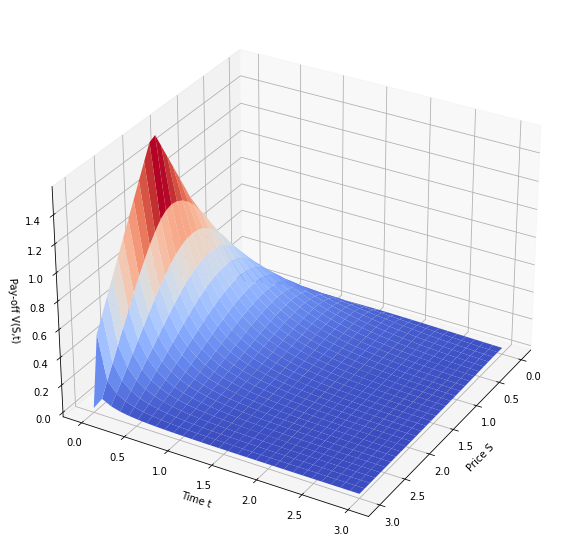

In [ ]:
####
#Testing different inital conditions with implicit Euler
strike = 2

kT = 0.1
hT = 0.1

lastT = 3
stpT = 3

Mt = int(lastT/hT)
Nt = int(stpT/kT)

C = 1
R = 1
S = 1

#
strike = 0.2
hit = 1.6

xt = np.linspace(0,lastT,Mt)

for i in range(len(xt)):
    xt[i] = max(xt[i] - strike,0) - 2*max(xt[i] - (strike + hit),0) + max(xt[i] - (strike + 2*hit),0)


tT = np.linspace(0,stpT,Nt)
init = initial_time(tT,C,xt[0])

T = np.zeros((2,Nt))
T[0] = init

f0 = np.zeros((Nt,Mt),dtype = float)

test2 = impEuler(hT,kT,xt,T,f0,endcoords = (lastT,stpT))



0.496


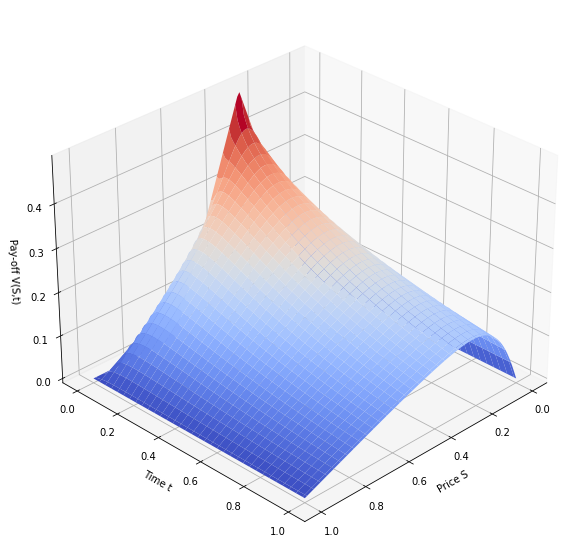

In [ ]:
##problem 2a
#####
#IMEX
####

#arctan business
def phi(r, sigma1 = 1, sigma2 = 2):
    return (sigma1**2)+(((sigma2**2)-(sigma1**2))/2)*(1+(2/np.pi)*np.arctan(r))

strike = 0
hit = 0.5
M4 = 101
N4 = 101

h = 1/M4
k = 1/N4

T4 = np.zeros(N4,dtype = float)
x4 = np.linspace(first,last,M4)
for i in range(len(x4)):
    x4[i] = max(x4[i] - strike,0) - 2*max(x4[i] - (strike + hit),0) + max(x4[i] - (strike + 2*hit),0)

def IMEX(M,N,x0,t0,sig1 = 1, sig2 = 2, show = True):
    """
    M: int, steps in space
    N: int, steps in time
    x0: array, initialvalues for t = 0
    t0: array, initialvalues for x = 0, often 0
    show: Bool, plotts the solution if True
    ####
    return: array, løsningsflaten U
    """

    #we'll only plot on [0,1]x[0,1], thus:
    space = np.linspace(0,1,M)
    time = np.linspace(0,1,N)

    #A tridiagonal matrix is necessary, first our diagonals
    diag4 = 2*np.ones(M, dtype = float)
    notDiag = -1*np.ones(M-1, dtype = float)

    #Our iteration matrix A, need modification in the loop
    A = 0.5*diags([notDiag,diag4,notDiag],[-1,0,1],shape = (M-2,M-2)).toarray()
    I = np.identity(M-2,dtype = float)

    #solution array
    U = np.zeros((N,M), dtype = float)

    #initalvalues
    U[0] = x0
    U[:,0] = t0

    #the matrix A has different koefficients for each row, they are partially found here
    coeffs = k * (np.arange(1,M-1,dtype = float))**2

    for i in range(1,N):
        delta2_x = U[i-1][2::] - 2*U[i-1][1:-1] + U[i-1][0:-2]    #central difference using arrays
        phis = phi(delta2_x/h**2,sig1,sig2)                       #arctan business
        co = coeffs * phis                                        #coefficients which needed in A are finished here
        matr = diags([co],[0],shape = (M-2,M-2)).toarray()        #matrix with coefficients on the diagonal, 0 otherwise
        B = np.dot(matr,A) + I                                    #this is the matrix whichs is multiplied with u^{n+1}, so it must be inveted 
        binv = np.linalg.inv(B)                                   #inverting the iteration matrix, so u^{n+1} = binv * u_n
        U[i][1:-1] = np.dot(binv,U[i-1][1:-1])                    #oppdating the solution array

    if show:
        xv,tv = np.meshgrid(space,time)

        fig = plt.figure(figsize = (10,10))
        ax = fig.add_subplot(111, projection = '3d')
        ax.plot_surface(xv,tv,U,cmap=cm.coolwarm)
        ax.view_init(azim=45)
        ax.set_ylabel("Time t")
        ax.set_xlabel("Price S")
        ax.set_zlabel("Pay-off V(S,t)")

        print(np.amax(U))
        plt.show()

    return U

homie = IMEX(M4,N4,x4,T4,sig1 = 1,sig2 = 3)

Euler order: 0.3603007802492767
Backwards order: 0.3617082880394139
Crank-Nic order: 0.3375437435769455


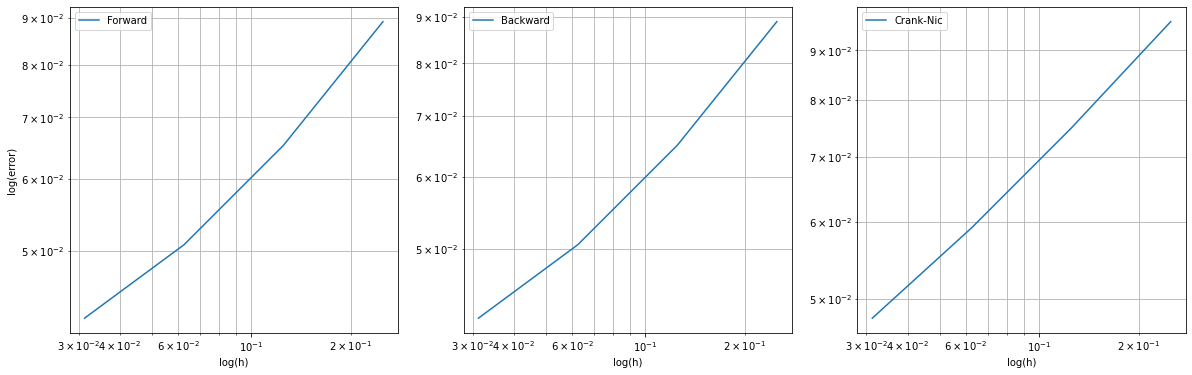

In [ ]:
######
#error analyisis
#####

#Fixed time step
strike = 1
kErr = 0.0005
hErr = np.array([0.25/(2**i) for i in range(4)])

lastErr = 1
stopErr = 1

C = 1
R = 1
S = 1

nErr = int(stopErr/kErr)
mErr = np.array(lastErr/hErr,dtype = int)

#initalvalues
tErr = np.linspace(0,stopErr,nErr)

#the boundary conditions
testErr = np.zeros((2,nErr))
testErr[0] = test_func(0,tErr)
testErr[1] = test_func(1,tErr)

#the array in which the errors are stored
Errey = np.zeros((3,len(hErr)),dtype = float)


for i in range(len(hErr)):
    Mi = int(lastErr/hErr[i])

    xErr = np.linspace(0,lastErr,Mi)
    testInit = test_func(xErr,0)

    xvErr,tvErr = np.meshgrid(xErr,tErr)
    fvals = LF(xvErr,tvErr,test_func,S,R,C)
    analytic = test_func(xvErr,tvErr)

    U1 = Euler(hErr[i], kErr, testInit, testErr, fvals, endcoords = (lastErr,stopErr),show = False)
    U2 = impEuler(hErr[i], kErr, testInit, testErr, fvals, endcoords = (lastErr,stopErr),show = False)
    U3 = crankNicolson(hErr[i], kErr, testInit, testErr, fvals, endcoords = (lastErr,stopErr),show = False)

    err1 = np.amax(abs(analytic - U1))
    err2 = np.amax(abs(analytic - U2))
    err3 = np.amax(abs(analytic - U3))

    Errey[0][i] = err1
    Errey[1][i] = err2
    Errey[2][i] = err3


order1 = np.polyfit(np.log(hErr),np.log(Errey[0]),1)[0]
order2 = np.polyfit(np.log(hErr),np.log(Errey[1]),1)[0]
order3 = np.polyfit(np.log(hErr),np.log(Errey[2]),1)[0]
print(f"Euler order: {order1}\nBackwards order: {order2}\nCrank-Nic order: {order3}")


fig, axes = plt.subplots(nrows = 1,ncols = 3,figsize = (20,6))
axes[0].loglog(hErr,Errey[0], label = "Forward")
axes[0].legend()

axes[1].loglog(hErr,Errey[1], label = "Backward")
axes[1].legend()

axes[2].loglog(hErr,Errey[2], label = "Crank-Nic")
axes[2].legend()

axes[0].set_xlabel("log(h)")
axes[1].set_xlabel("log(h)")
axes[2].set_xlabel("log(h)")

axes[0].grid(True, which="both")
axes[1].grid(True, which="both")
axes[2].grid(True, which="both")

axes[0].set_ylabel("log(error)")
plt.show()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:231: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])
Euler order: nan
Backwards order: 1.0008120007865287
Crank-Nic order: -0.044910343544321885


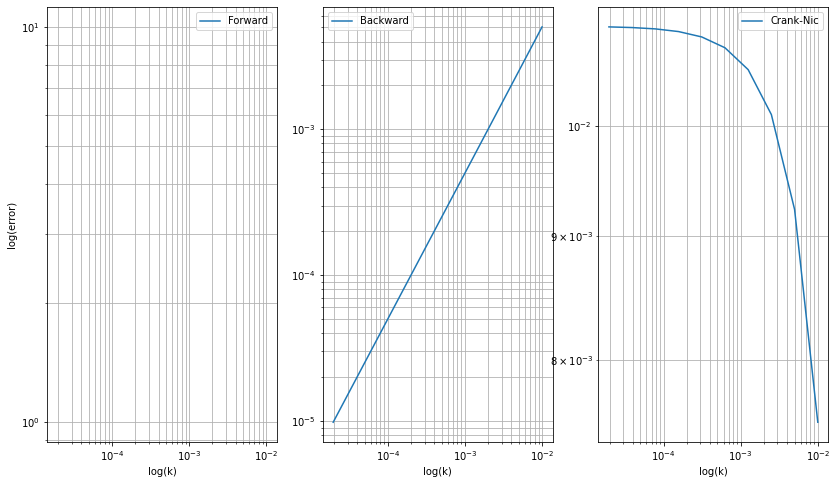

In [ ]:
#Fixed space step

strike = 1
kErr = np.array([0.01/(2**i) for i in range(10)])
hErr = 0.2

lastErr = 1 #space
stopErr = 1 #time

C = 1
R = 1
S = 1

nErr = np.array(stopErr/kErr,dtype = int)
mErr = int(lastErr/hErr)

#initalvalues
xErr = np.linspace(0,lastErr,mErr)
testInit = test_func(xErr,0)


#error array
Errey = np.zeros((3,len(kErr)),dtype = float)


for i in range(len(kErr)):
    Ni = int(stopErr/kErr[i])
    tErr = np.linspace(0,stopErr,Ni)

    testErr = np.zeros((2,Ni))
    testErr[0] = test_func(0,tErr)
    testErr[1] = test_func(lastErr,tErr)


    xvErr,tvErr = np.meshgrid(xErr,tErr)
    fvals = LF(xvErr,tvErr,test_func,S,R,C)
    refsol = Euler(0.001, kErr[i], testInit, testErr, fvals, endcoords = (lastErr,stopErr),show = False)


    U1 = Euler(hErr, kErr[i], testInit, testErr, fvals, endcoords = (lastErr,stopErr), show = 0)
    U2 = impEuler(hErr, kErr[i], testInit, testErr, fvals, endcoords = (lastErr,stopErr), show = 0)
    U3 = crankNicolson(hErr, kErr[i], testInit, testErr, fvals, endcoords = (lastErr,stopErr), show = 0)

    err1 = np.amax(abs(refsol[:,-2] - U1[:,-2]))
    err2 = np.amax(abs(refsol[:,-2] - U2[:,-2]))
    err3 = np.amax(abs(refsol[:,-2] - U3[:,-2]))

    Errey[0][i] = err1
    Errey[1][i] = err2
    Errey[2][i] = err3


order1 = np.polyfit(np.log(kErr),np.log(Errey[0]),1)[0]
order2 = np.polyfit(np.log(kErr),np.log(Errey[1]),1)[0]
order3 = np.polyfit(np.log(kErr),np.log(Errey[2]),1)[0]
print(f"Euler order: {order1}\nBackwards order: {order2}\nCrank-Nic order: {order3}")

fig, axes = plt.subplots(nrows = 1,ncols = 3,figsize = (14,8))
axes[0].loglog(kErr,Errey[0], label = "Forward")
axes[0].legend()

axes[1].loglog(kErr,Errey[1], label = "Backward")
axes[1].legend()

axes[2].loglog(kErr,Errey[2], label = "Crank-Nic")
axes[2].legend()

axes[0].set_xlabel("log(k)")
axes[1].set_xlabel("log(k)")
axes[2].set_xlabel("log(k)")

axes[0].grid(True, which="both")
axes[1].grid(True, which="both")
axes[2].grid(True, which="both")

axes[0].set_ylabel("log(error)")
plt.show()

0.0001234567901234568
Maximum value: 1.0


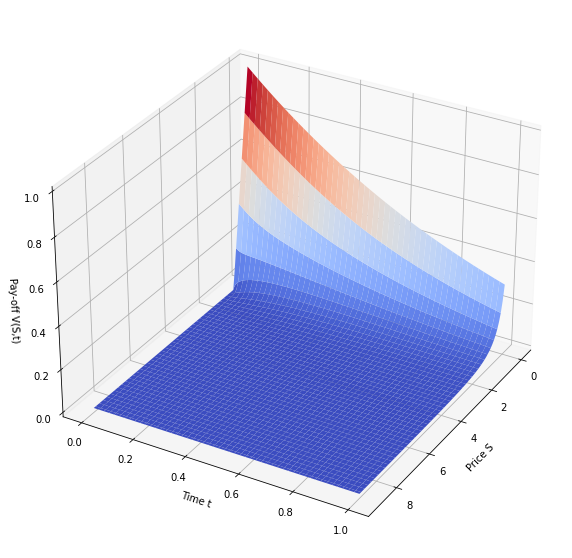

Maximum value: 3.476192473579269e+69


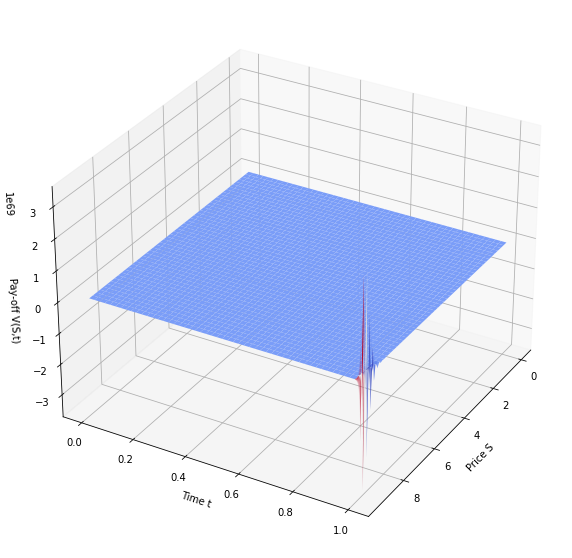

In [ ]:
def CFL(h,X,sig):
    """
    returns h, given by the CFL formula: k/h^2 < 1/x^2sig^2
    """
    return (h/(X*sig))**2

C = 1
R = 1
S = 1.0
strike = 1


#space
first = 0
last = 9.0

h = 0.1
k = CFL(h,last,S) 
print(k)



#time
start = 0
stp = 1

M1 = int(last/h)
N1 = int(stp/k)


#Her lager vi initialverdier
x0 = np.linspace(first,last,M1)

for i in range(len(x0)):
    x0[i] = max(strike - x0[i],0)


t = np.linspace(0,stp,N1)
T0 = initial_time(t,C,x0[0])

T = np.zeros((2,N1))
T[0] = T0

f0 = np.zeros((N1,M1),dtype = float)
ans1 = Euler(h,k,x0,T,f0,endcoords = (last,stp))

last = 9.5
M1 = int(last/h)
N1 = int(stp/k)

x0 = np.linspace(first,last,M1)

for i in range(len(x0)):
    x0[i] = max(strike - x0[i],0)


t = np.linspace(0,stp,N1)
T0 = initial_time(t,C,x0[0])

T = np.zeros((2,N1))
T[0] = T0

f0 = np.zeros((N1,M1),dtype = float)

ans2 = Euler(h,k,x0,T,f0,endcoords = (last,stp))

Maximum value: 1.0


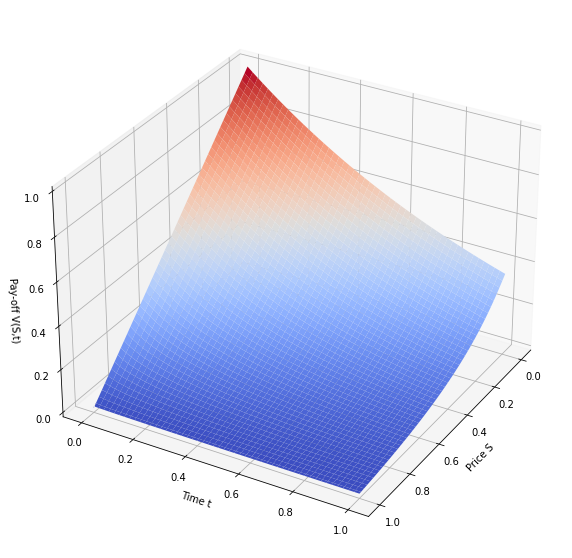

Maximum value: 1.0


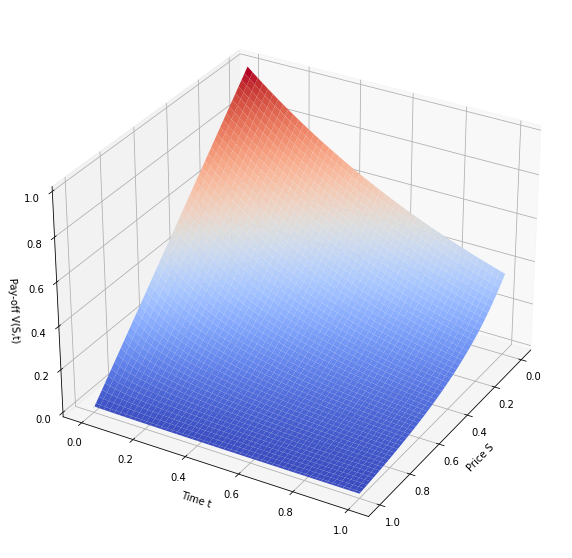

Maximum value: 1.0


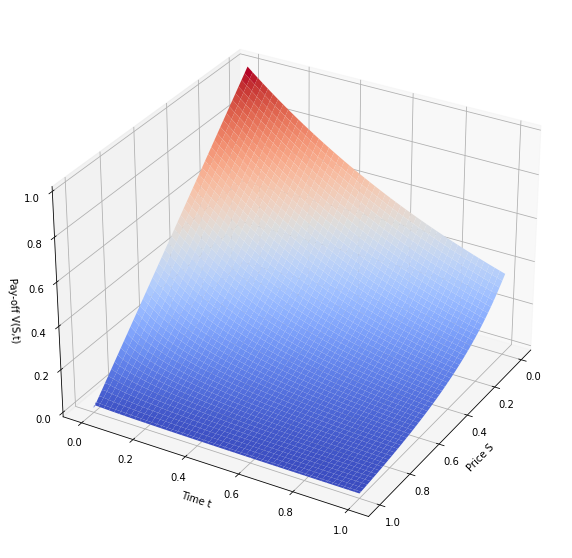

Euler: 1.686025619506836
imp: 25.12408995628357
crank: 24.99994444847107


In [ ]:
import time


C = 1
R = 1
S = 1.0
strike = 1

k = 0.0001
h = 0.01

#####
#Which is fastest for the same problem?
#####
#space
first = 0
last = 1

start = 0
stp = 1

M1 = int(last/h)
N1 = int(stp/k)


#Her lager vi initialverdier
x0 = np.linspace(first,last,M1)

for i in range(len(x0)):
    x0[i] = max(strike - x0[i],0)


t = np.linspace(0,stp,N1)
T0 = initial_time(t,C,x0[0])

T = np.zeros((2,N1))
T[0] = T0

f0 = np.zeros((N1,M1),dtype = float)


t1 = time.time()
ans1 = Euler(h,k,x0,T,f0,endcoords = (last,stp))
t2 = time.time()
euTime = t2-t1

t1 = time.time()
ans1 = impEuler(h,k,x0,T,f0,endcoords = (last,stp))
t2 = time.time()
impTime = t2-t1

t1 = time.time()
ans1 = crankNicolson(h,k,x0,T,f0,endcoords = (last,stp))
t2 = time.time()
crankTime = t2-t1

print(f"Euler: {euTime}")
print(f"imp: {impTime}")
print(f"crank: {crankTime}")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5c31f8a9-08a3-4ca8-9fed-c47f6d7a28fb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>